# Phases with Electrically Charged Species

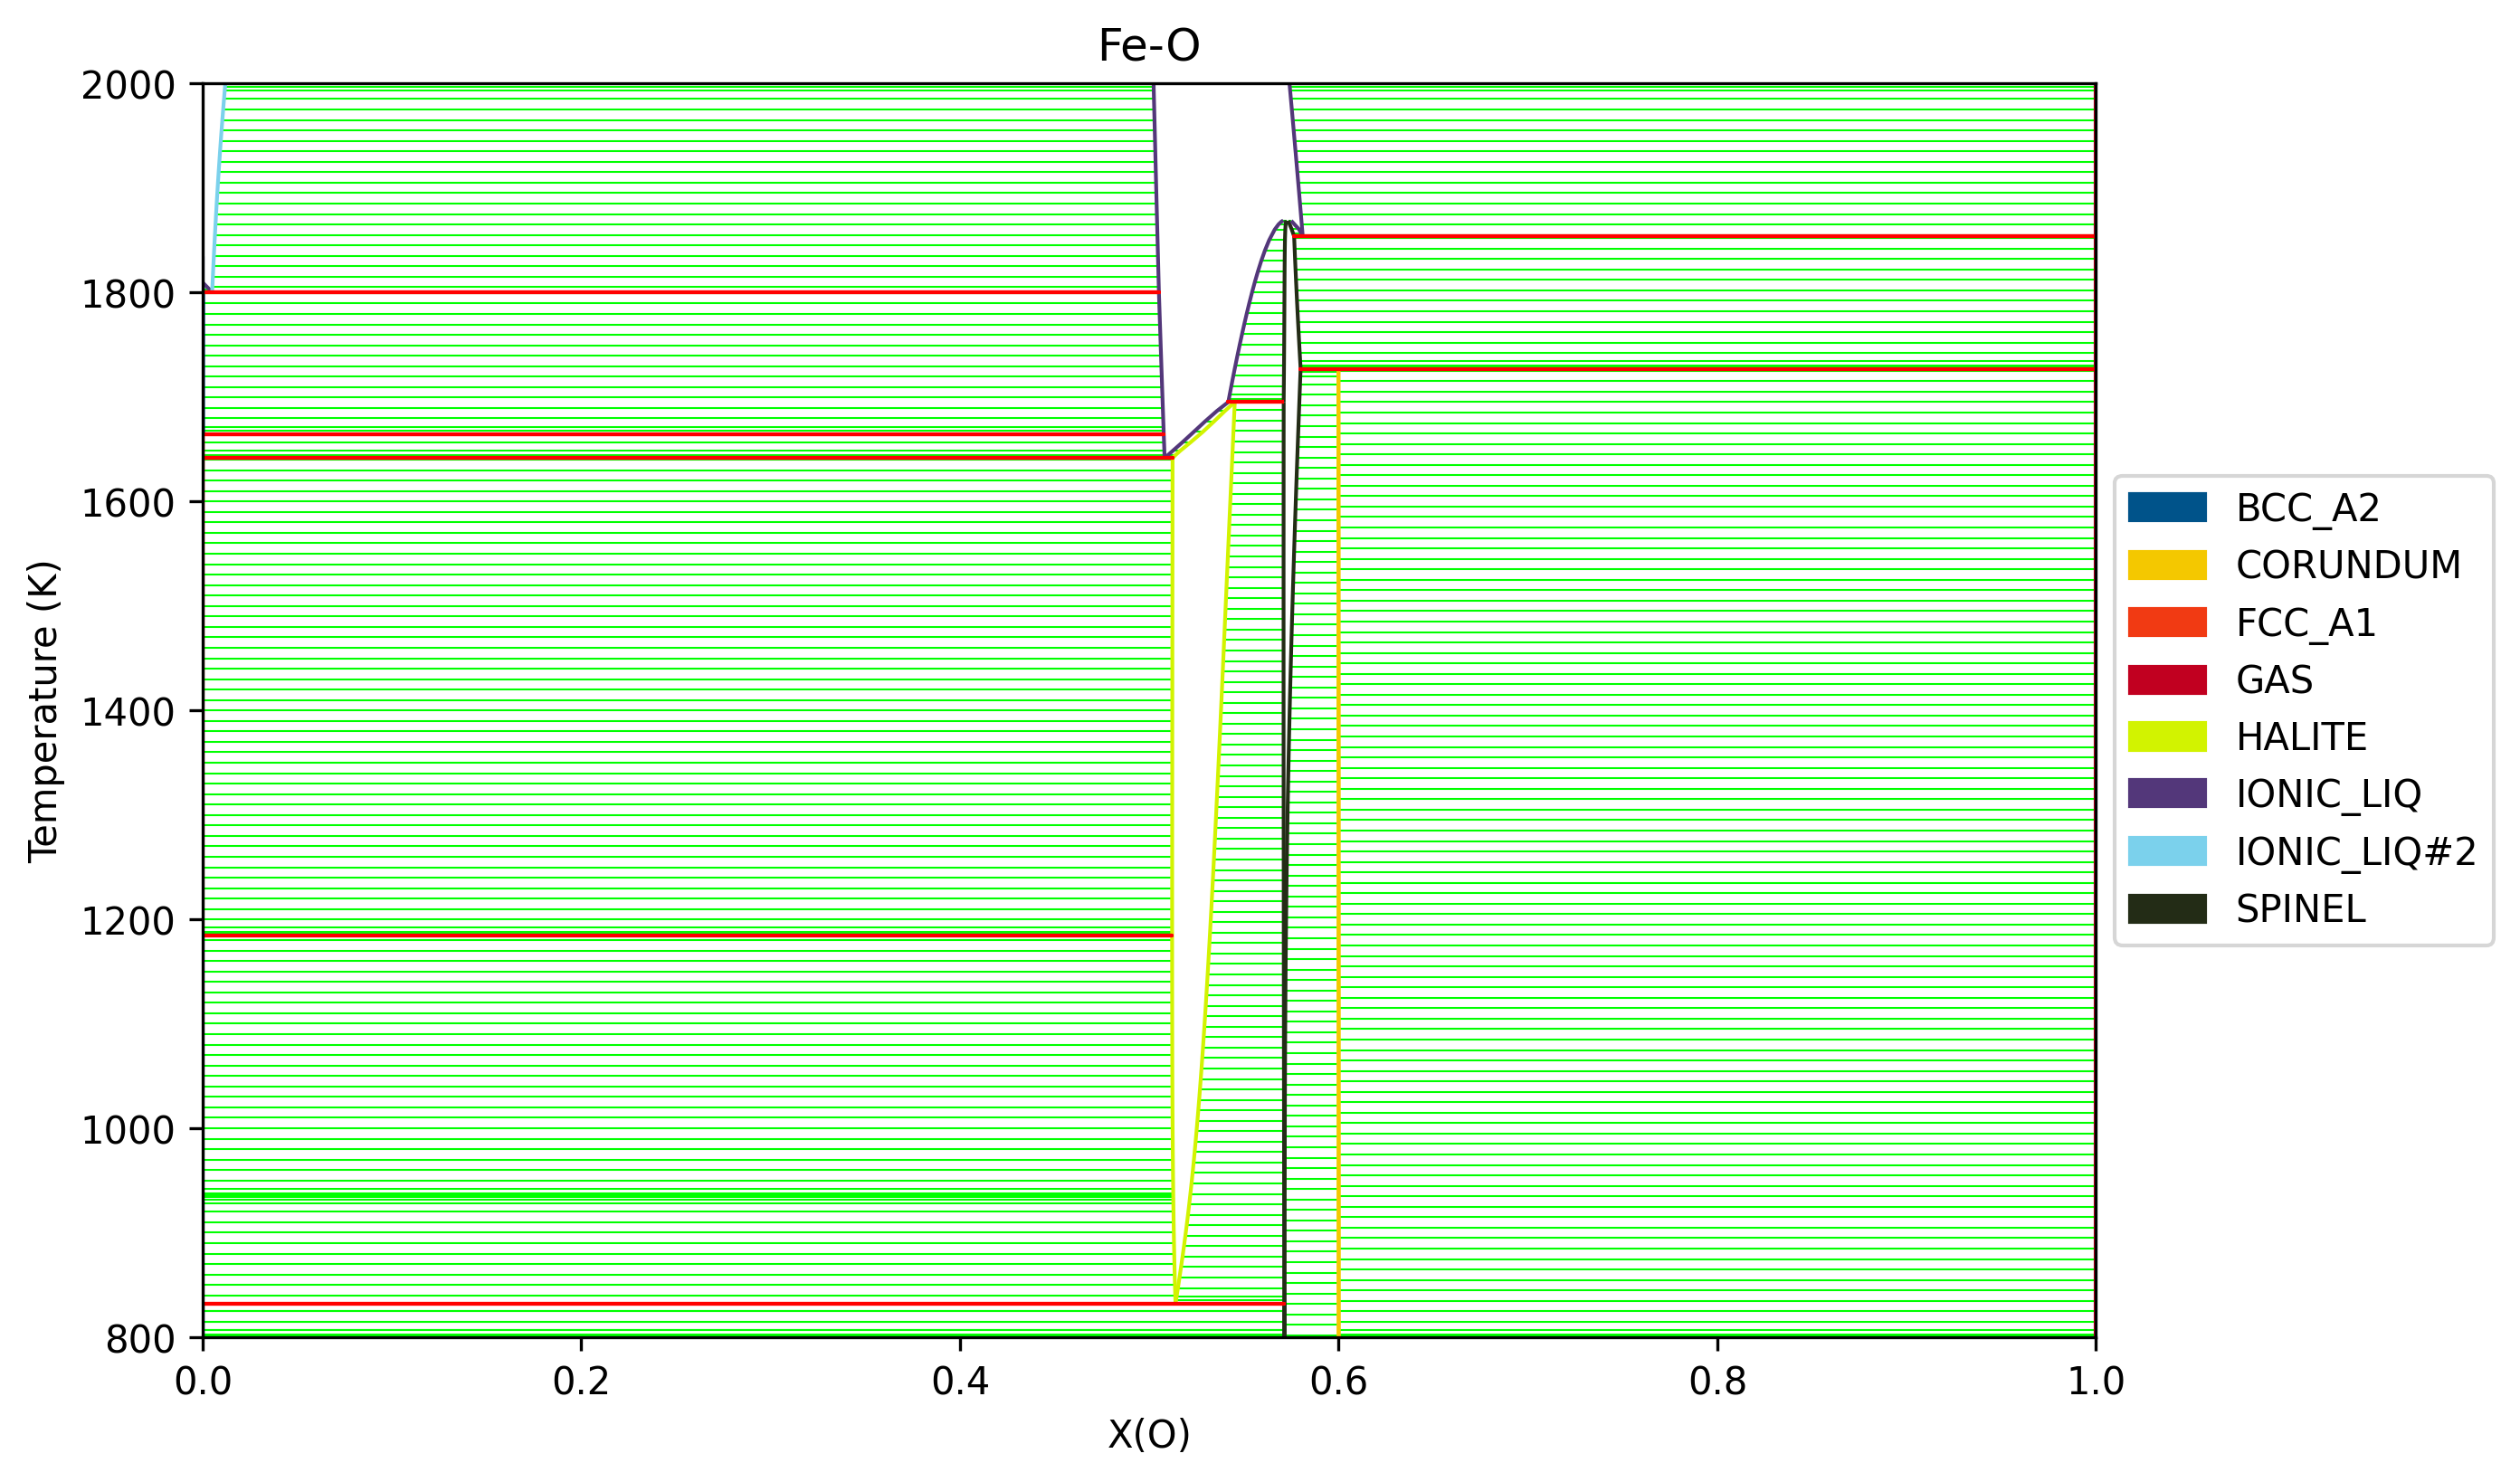

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, binplot
import pycalphad.variables as v

# Load database and choose the phases that will be considered
dbf = Database('Fe-O.tdb')
phases = sorted(dbf.phases.keys())

# Create a matplotlib Figure object and get the active Axes
fig = plt.figure(figsize=(9,6), dpi=300)
axes = fig.gca()
# Compute the phase diagram and plot it on the existing axes using the `plot_kwargs={'ax': axes}` keyword argument
binplot(dbf, ['FE', 'O', 'VA'], phases, {v.X('O'):(0,1,0.01), v.T: (800, 2000, 10), v.P:101325, v.N: 1},
        plot_kwargs={'ax': axes})

plt.show()

In [2]:
from pycalphad.mapping import StepStrategy, plot_step

strategy = StepStrategy(dbf, ['FE', 'O', 'VA'], phases, {v.N: 1, v.T: (700, 2000, 10), v.P: 1e5, v.X('O'): 0.55})
strategy.do_map()

Text(0.5, 1.0, 'Phase fractions vs T @ X(O) = 0.55')

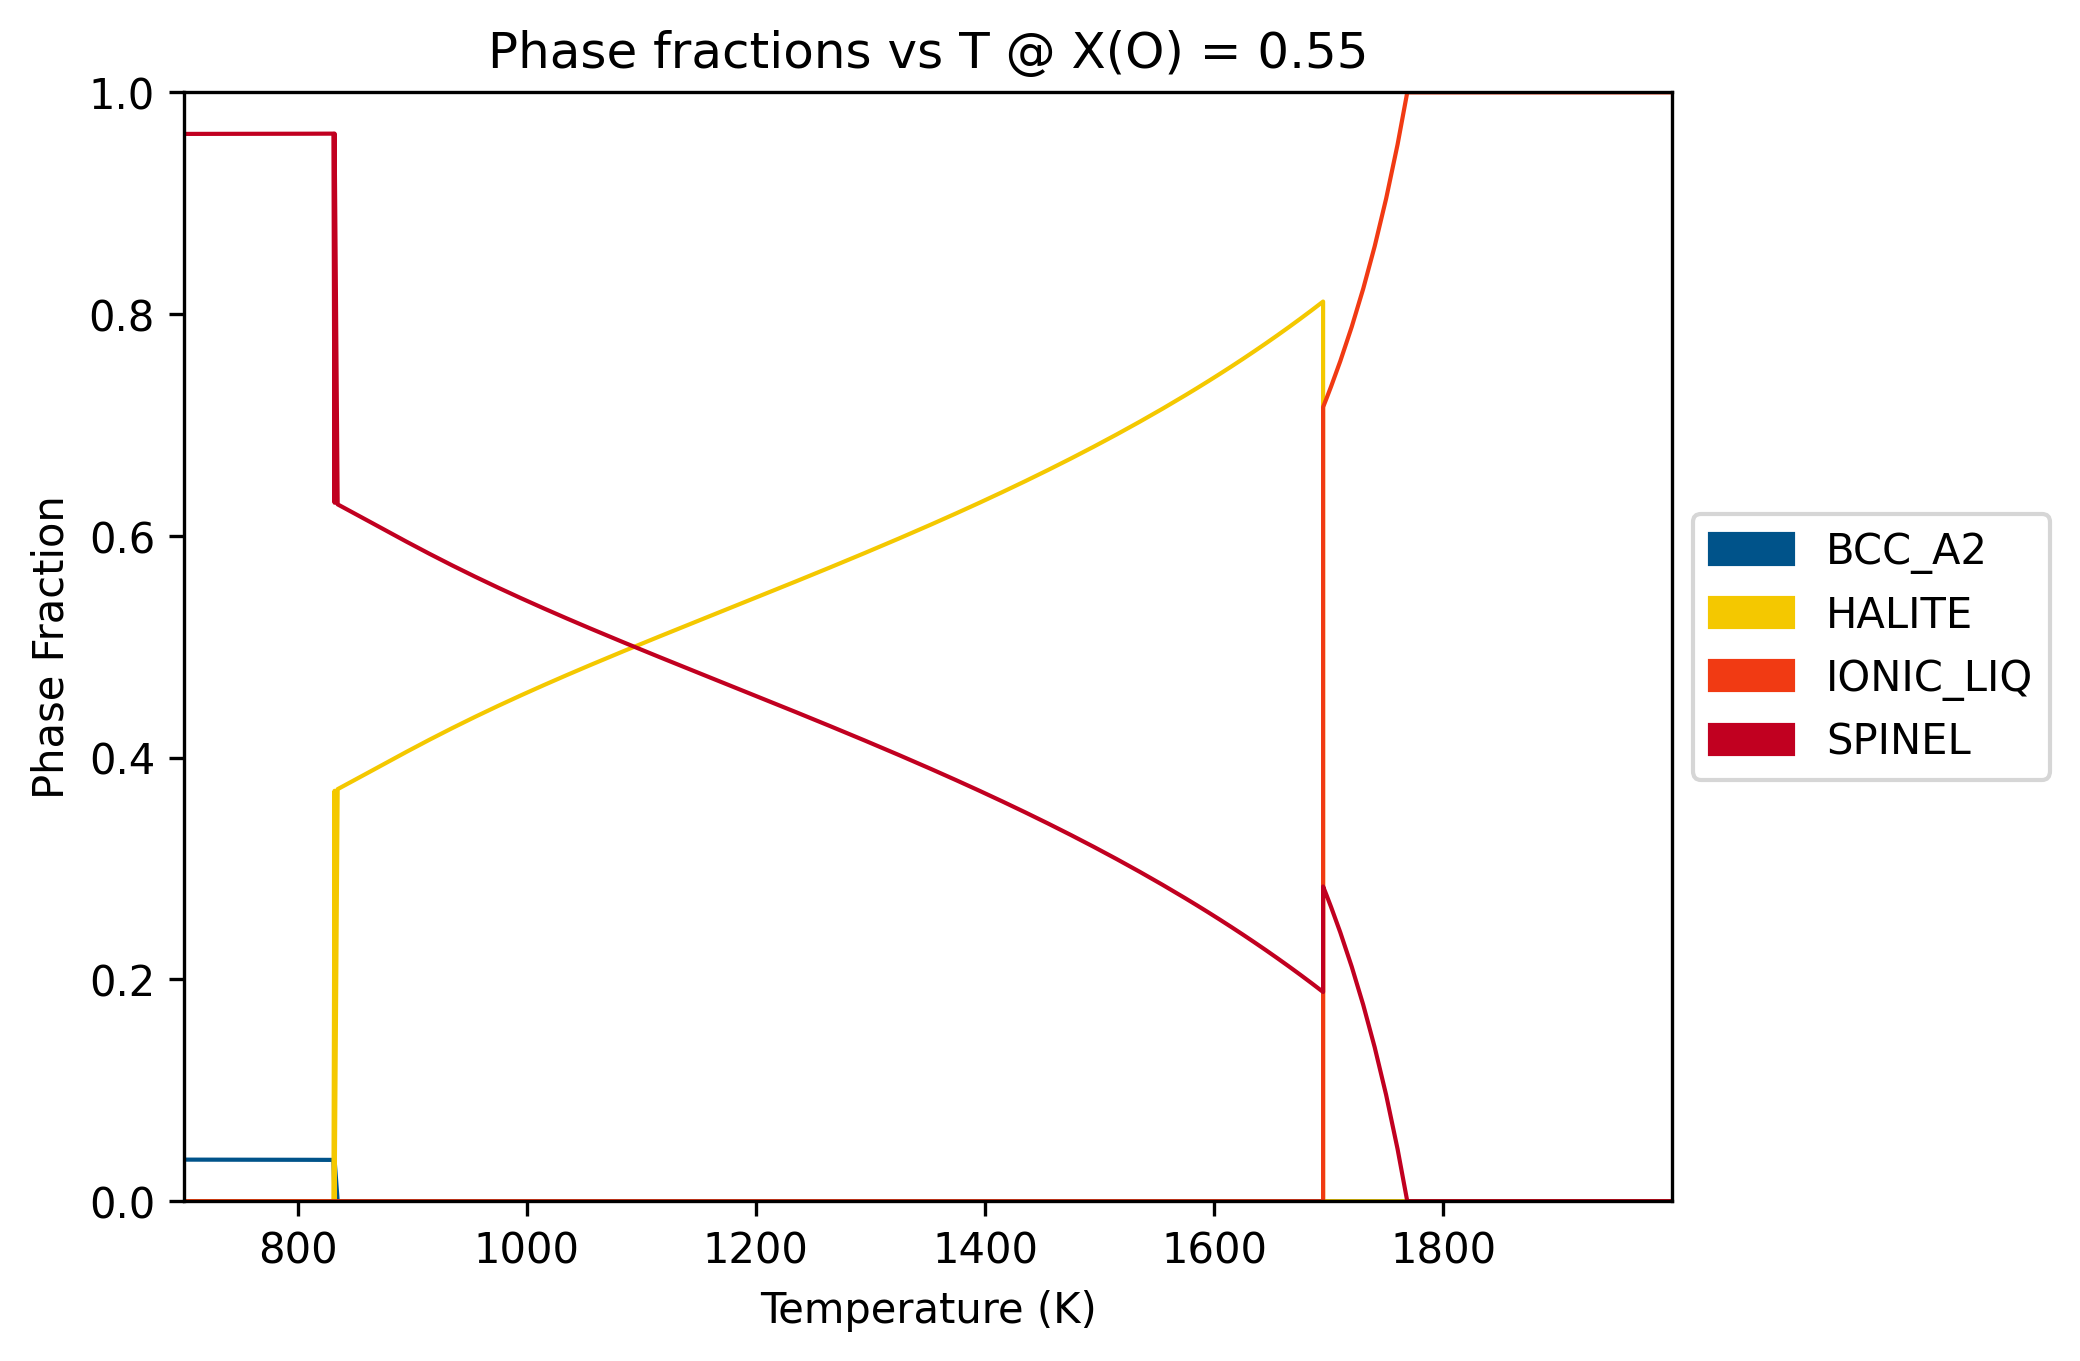

In [3]:
fig = plt.figure(dpi=300)
ax = fig.gca()
plot_step(strategy, ax=ax)
ax.set_title('Phase fractions vs T @ X(O) = 0.55')

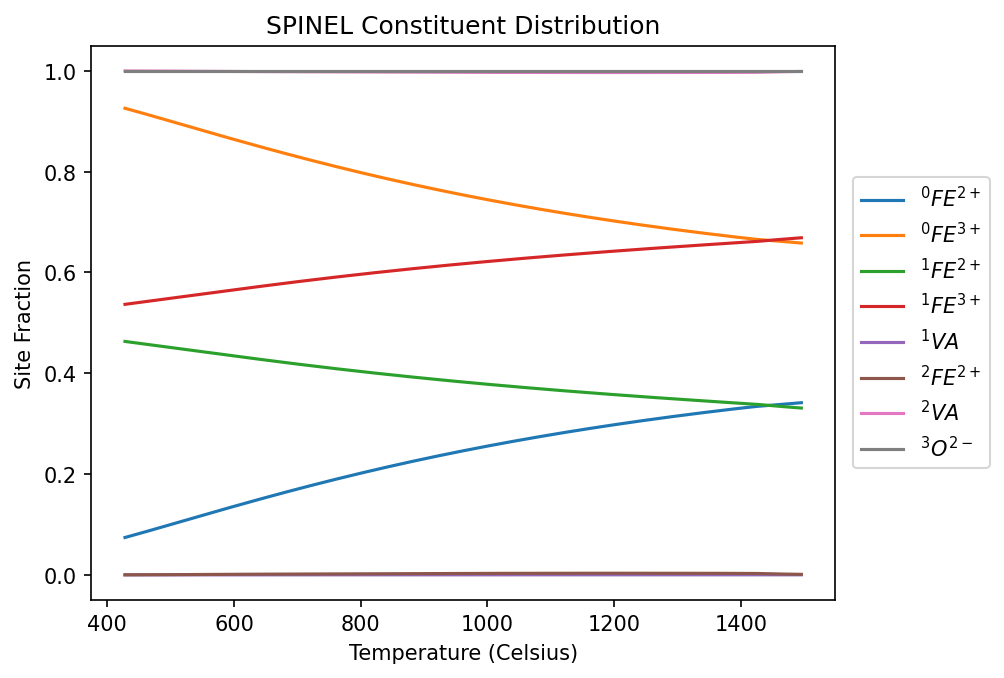

In [4]:
from pycalphad import Model

fig = plt.figure(dpi=150)
ax = fig.add_subplot()

def create_label(sf_idx, sf_sym):
    # Note: This formatting assumes multiplicity of 1 for all species
    species_constituents = ''.join(
            ['{}'.format(el) for el, val in sorted(sf_sym.species.constituents.items(), key=lambda t: t[0])])
    subl_idx = sf_sym.sublattice_index
    charge = sf_sym.species.charge
    if charge == 0:
        charge = ''
    elif charge > 0:
        charge = str(charge)+'+'
    else:
        charge = str(abs(charge))+'-'
    label_name = '$^{1}{0}^{{{2}}}$'.format(species_constituents, subl_idx, charge)
    return label_name

desired_phase = 'SPINEL'
mod = Model(dbf, ['FE', 'O', 'VA'], desired_phase)

# Since the site fraction variable is specific to SPINEL and constituent, the strategy will return a
# single x,y line corresponding to the entire system
for sf_idx, sf_sym in enumerate(mod.site_fractions):
    data = strategy.get_data(v.T, sf_sym).data[0]
    indices = data.y != 0
    ax.plot(data.x[indices]-273.15, data.y[indices], label=create_label(sf_idx, sf_sym))
    
ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.set_xlabel('Temperature (Celsius)')
ax.set_ylabel('Site Fraction')
ax.set_title(f'{desired_phase} Constituent Distribution');

Alternatively, phase fraction and site fractions can be computed and plotted through the equilibrium API.

In [5]:
from pycalphad import equilibrium
eq = equilibrium(dbf, ['FE', 'O', 'VA'], phases,
                 {v.N: 1, v.T: (700, 2000, 10), v.P: 1e5, v.X('O'): 0.55})

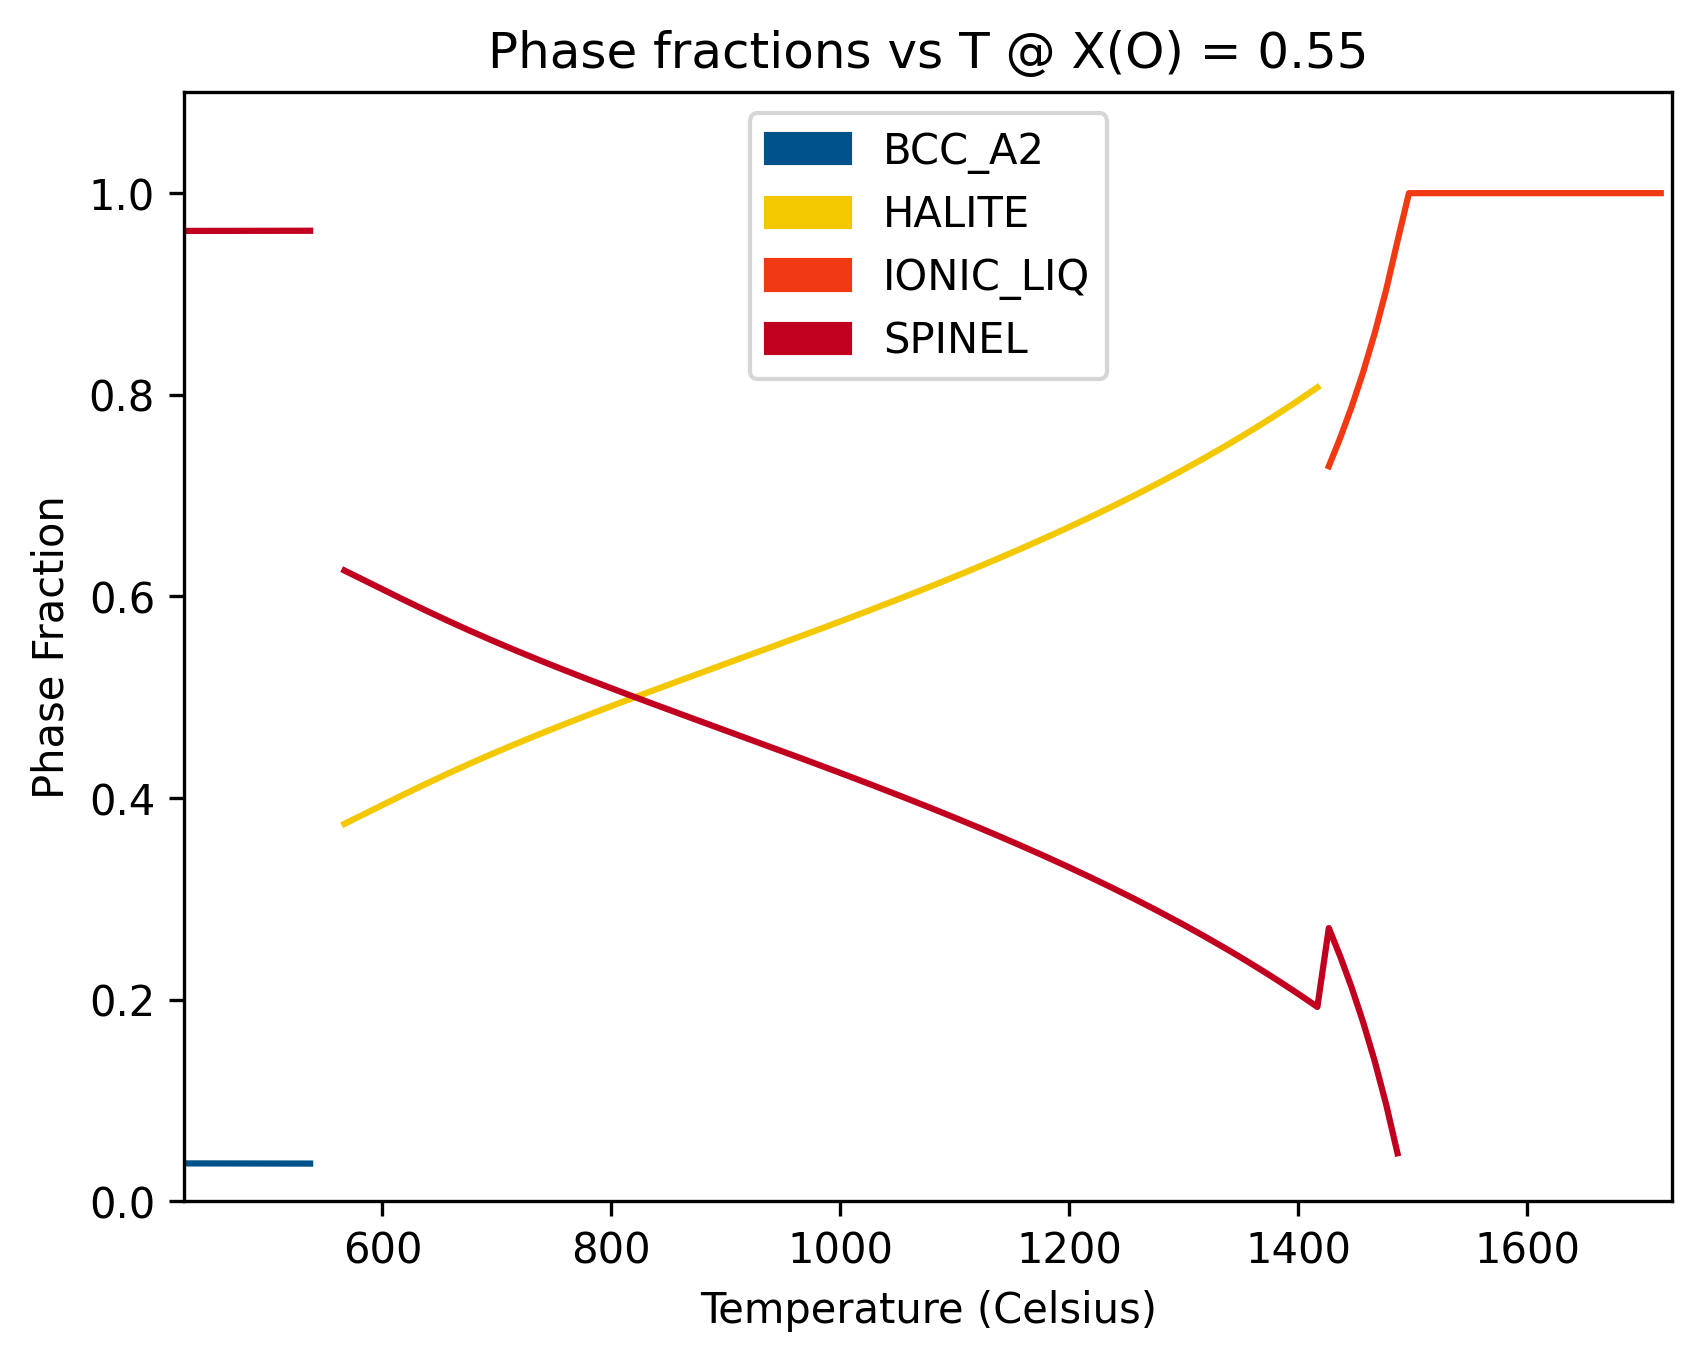

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pycalphad.plot.utils import phase_legend
phases = sorted(set(eq.Phase.values.flatten()) - {''})

fig = plt.figure(dpi=300)
ax = fig.gca()
phase_handles, phasemap = phase_legend(phases)
ax.set_title('Phase fractions vs T @ X(O) = 0.55')
ax.set_xlabel('Temperature (Celsius)')
ax.set_ylabel('Phase Fraction')
ax.set_ylim((0,1.1))
ax.set_xlim((700-273.15, 2000-273.15))

for name in phases:
    ax.plot(np.squeeze(eq.T.broadcast_like(eq.NP)-273.15), np.squeeze(eq.NP.where(eq.Phase == name)),
             color=phasemap[name], label=name)
plt.gca().legend(phase_handles, phasemap, loc='upper center')

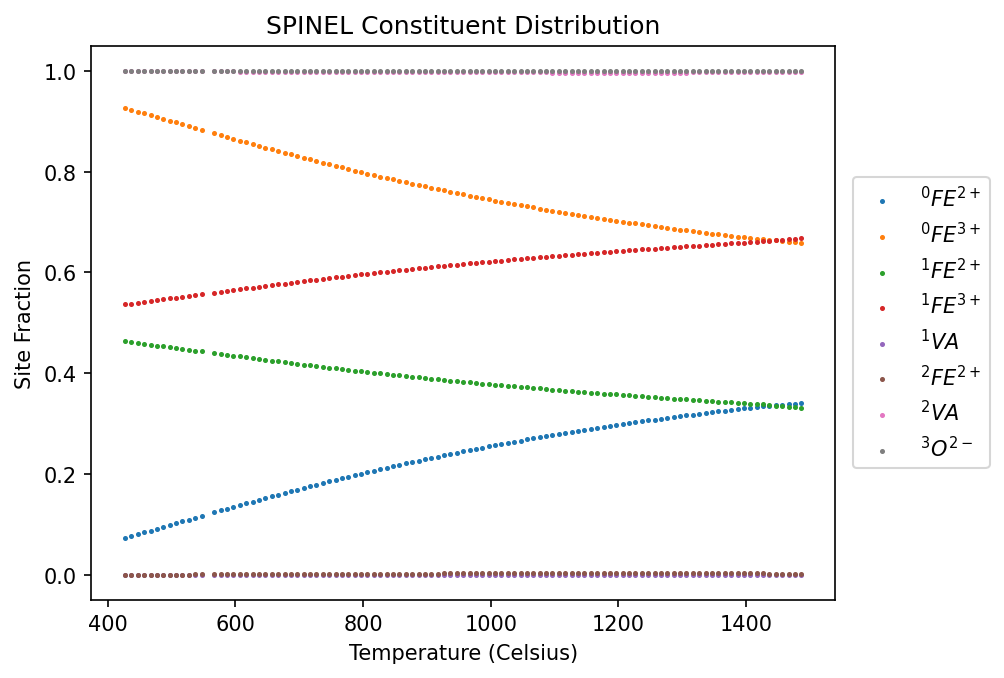

In [8]:
from pycalphad import Model
fig = plt.figure(dpi=150)
ax = fig.add_subplot()

desired_phase = 'SPINEL'

mod = Model(dbf, ['FE', 'O', 'VA'], desired_phase)

# Plot site fractions by index and label them using the ._latex() feature of SymPy symbols
for sf_idx, sf_sym in enumerate(mod.site_fractions):
    masked_eq_res = eq.where(eq.Phase == desired_phase).isel(internal_dof=sf_idx)
    # Note: This formatting assumes multiplicity of 1 for all species
    species_constituents = ''.join(
            ['{}'.format(el) for el, val in sorted(sf_sym.species.constituents.items(), key=lambda t: t[0])])
    subl_idx = sf_sym.sublattice_index
    charge = sf_sym.species.charge
    if charge == 0:
        charge = ''
    elif charge > 0:
        charge = str(charge)+'+'
    else:
        charge = str(abs(charge))+'-'
    label_name = '$^{1}{0}^{{{2}}}$'.format(species_constituents, subl_idx, charge)
    temperature_in_celsius = masked_eq_res.T.broadcast_like(masked_eq_res.Y).squeeze() - 273.15
    ax.scatter(temperature_in_celsius, masked_eq_res.Y.squeeze(), s=2, label=label_name)

ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax.set_xlabel('Temperature (Celsius)')
ax.set_ylabel('Site Fraction')
ax.set_title(f'{desired_phase} Constituent Distribution');